In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, binom, beta, uniform
import pymc3 as pm
import arviz as az

# Problem 1

In [2]:
def bernoulli_sampling(p, n):
    """
    Simulate n tosses of a coin which gives heads with probability 
    p. Then use that sample to calculate the posterior distribution on 
    p given a uniform prior.

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate

    Returns:
        (float): The MAP estimate of p
    """
    
    # use a uniform prior to calculate the posterior distribution ########
    # set up variables
    grid = np.linspace(0, 1, 101)
    sample = binom.rvs(n, p)
    numer_list = []
    denom = 0
    
    # iterate through the grid points to find posterior values
    for theta in grid:
        x_given_theta = binom.pmf(sample, n, theta)
        numer_list.append(x_given_theta * uniform.pdf(theta, 0, 1))
        denom = denom + (x_given_theta * uniform.pdf(theta, 0, 1))
        
    # create list of posterior values at gridpoints
    theta_given_x = [numer / denom for numer in numer_list]
    posterior = grid[np.argmax(theta_given_x)]
    
    # plot results #######################################################
    plt.title('Bernoulli Sampling n = '+str(n))
    plt.plot(grid, theta_given_x, label='p = '+str(p))
    plt.legend()
    plt.show
    
    return posterior

0.18

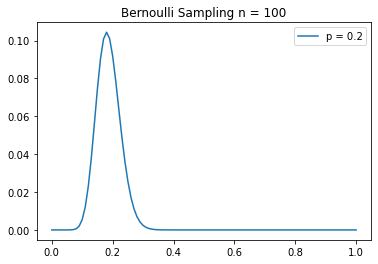

In [3]:
bernoulli_sampling(0.2, 100)

# Problem 2

In [4]:
def non_uniform_prior(p, n, prior):
    """
    Generate a sample of size n that has a Bernoulli
    distribution with a probability parameter p.
    Use Bayes' theorem to compute the posterior distribution
    for the given prior and the generated sample:
    
        P(t|x) = P(x|t) P(t) / P(x)
    
    Plot both prior and posterior distributions between [0, 1]

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate
        prior (scipy dist): the prior distribution on p

    Returns:
        (float): MAP estimate
    """
    
    # use a non-uniform prior to calculate the posterior distribution ####
    # set up variables
    grid = np.linspace(0, 1, 101)
    sample = binom.rvs(n, p)
    numer_list = []
    denom = 0
    
    # iterate through the grid points to find posterior values
    for theta in grid:
        x_given_theta = binom.pmf(sample, n, theta)
        numer_list.append(x_given_theta * prior.pdf(theta))
        denom = denom + (x_given_theta * prior.pdf(theta))
        
    # create list of posterior values at gridpoints
    theta_given_x = [numer / denom for numer in numer_list]
    posterior = grid[np.argmax(theta_given_x)]
    
    # plot results #######################################################
    plt.title('Non-Uniform Sampling n = '+str(n))
    plt.plot(grid, theta_given_x, label='p = '+str(p))
    plt.legend()
    plt.show
    
    return posterior

0.98

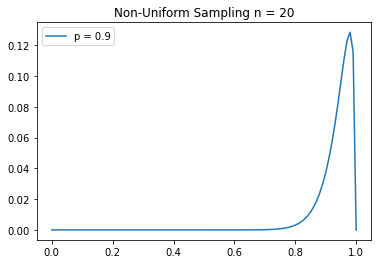

In [5]:
non_uniform_prior(0.9, 20, beta(5, 1.5))

0.61

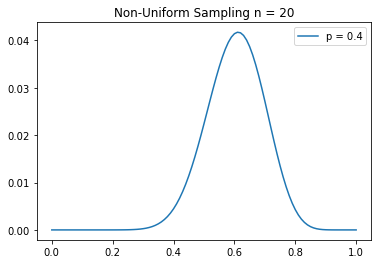

In [6]:
non_uniform_prior(0.4, 20, beta(5, 1.5))

The coin is much more likely to match our assumption modeled by the given beta distribution when it comes up heads 90% of the time in our sample as opposed to 40% of the time.

# Problem 3

In [7]:
def weather_forecast(transition_matrix, days=10):
    """
    Given the above transition matrix and assuming the 0th day is sunny,
    sample from the markov chain to give a possible forecast of the 10 following
    days. 
    """
    
    # set up variables ###################################################
    weather_types = {0:'sun', 1:'rain', 2:'wind'}
    forecast = [0]
    index = 0
    
    # iterate through days using the transition matrix to choose weather #
    for i in range(days - 1):
        forecast.append(np.random.choice(list(weather_types.keys()), \
                                         p=transition_matrix[index]))
        index = forecast[-1]
    
    return [weather_types[day] for day in forecast]

In [8]:
transition_matrix = np.array(
  [
    [0.6,0.1,0.3],
    [0.2,0.6,0.2],
    [0.3,0.4,0.3]
  ]
)

In [9]:
weather_forecast(transition_matrix)

['sun', 'sun', 'sun', 'rain', 'wind', 'wind', 'sun', 'sun', 'sun', 'rain']

# Problem 4

In [10]:
def posterior_sampling(data, n=1000):
    """
    Given data that flips a coin 100 times, assume the data are distributed 
    as Bernoulli(p) for some unknown value of p, where p has a prior of 
    Beta(1,1). Set up a PyMC3 model for this situation and sample from the 
    poterior n times. Print a trace plot. Return the mean for the posterior.
    
    Parameters:
        data (array): The coin flips
        n (int): number of samples to take from the posterior
        
    Returns:
        Mean (float): The average of the coin flips (estimated p)
    """

    # use monte carlo markov chains to take a sample #####################
    model = pm.Model()
    with model:
        # define prior distribution, desired distribution, and trace
        bet = pm.Beta('beta', 1, 1)
        y = pm.Bernoulli('y', bet, observed=data)
        trace = pm.sample(n)
        
        # plot using arviz 
        az.plot_trace(trace)
        
        # calculate posterior and mean
        post = trace['beta']
        mean = post.mean()
        
    return mean

In [11]:
data = bernoulli.rvs(0.2, size=30)

/home/celo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


0.1898238348458399

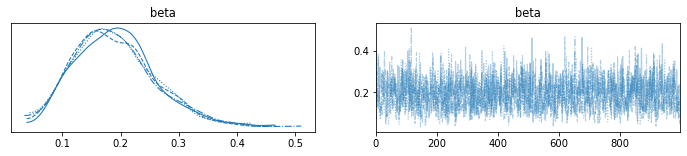

In [12]:
posterior_sampling(data)

# Problem 5

In [13]:
def height_model(observed_heights,m=180,s=10,alpha=2,beta=10,n=1000):

    """
    Given a dataset of the measured heights of 100 men, assume the data are
    distributed as Normal(mu,1/tau) where mu has a prior of Normal(m,s), and tau has
    a prior of Gamma(alpha,beta). Set up a PyMC3 model for this situation and sample 
    from the poterior n times. Print a trace plot for mu and tau. Return the mean 
    for the posterior of mu.
    
    Parameters:
        observed_heights (array): The measured heights of 100 men
        m (int): the mean in the prior distribution of mu
        s (int): the standard deviation in the prior distribution of mu
        alpha (int): the first component in the prior distibution of tau
        beta (int): the second component in the prior distribution of tau
        n (int): number of samples from the posterior
        
    Returns:
        mu_mean (float): the estimated value of mu
    """
    
    # use monte carlo markov chains to take a sample #####################
    model = pm.Model()
    with model:
        # define prior distribution, desired distribution, and trace
        mu = pm.Normal('mu', m, s)
        tau = pm.Gamma('tau', alpha, beta)
        y = pm.Normal('y', mu, 1/tau, observed=data)
        trace = pm.sample(n)
        
        # plot using arviz 
        az.plot_trace(trace)
        
        # calculate posterior and mean
        post = trace['mu']
        mean = post.mean()
        
    return mean

In [14]:
heights = np.random.normal(180,10,100)

/home/celo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


160.3589988936816

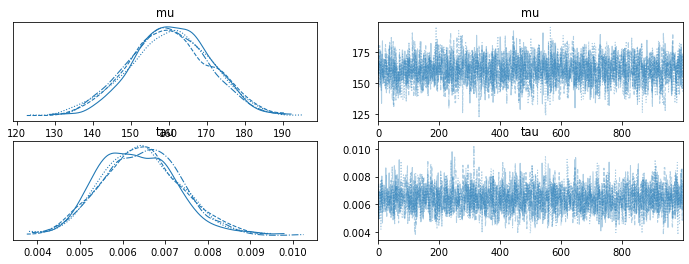

In [15]:
height_model(heights)